# Домашнее задание 6.Сегментация 

In [1]:
# импорт необходимых библиотек и модулей
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [2]:
#метрика модели
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

## Задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:

https://www.kaggle.com/carlolepelaars/camvid

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset

https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy

https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

## План решения

[0. Загрузка и обработка данных](#section_0)

[1. Подготовка данных](#section_1)

[2. Segmantational model Unet](#section_2)

[3. Рукописная Unet](#section_3)

[4. Выводы о результатах нейросетей](#section_4)

Используем датасет https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

## 0. Загрузка  и обработка данных<a id='section_0'></a>

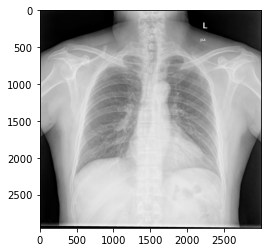

(2951, 3000, 3)
566


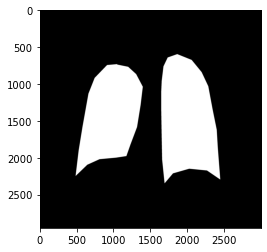

(2951, 3000, 3)
566


In [3]:
#директории с данными
#данные заранее подготовлены: отобраны 566 картинок и масок
path_imgs = 'datasets/CXR_png/'
path_masks = 'datasets/masks/'

#Картинка, ее размеры и количество
flist_image = os.listdir(path_imgs)
img0 = image.load_img(path_imgs+flist_image[1])
plt.imshow(img0)
plt.show()
print(np.shape(img0))
print(len(flist_image))

#Маска, ее размеры и количество
flist_mask = os.listdir(path_masks)
msk0 = image.load_img(path_masks+flist_mask[1])
plt.imshow(msk0)
plt.show()
print(np.shape(msk0))
print(len(flist_mask))

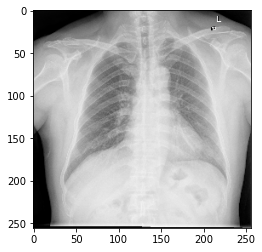

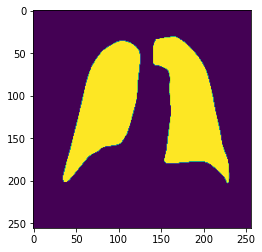

566
566


In [4]:
#Сжимаем картинки и маски, маски переводим в 1-канальный вид
images = []
masks = []
image_size = (256, 256)

for file in flist_image:
    img = cv2.imread(path_imgs+file)
    img = cv2.resize(img, (256, 256))
    images.append(img)

plt.imshow(images[0])
plt.show()

for file in flist_mask:
    msk = cv2.imread(path_masks+file)
    msk = cv2.resize(msk, (256, 256))
    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    masks.append(msk)

plt.imshow(masks[0])
plt.show()

print(len(images))
print(len(masks))

## 1. Подготовка данных<a id='section_1'></a>

In [5]:
#собираем данные (картинки) для модели
X = []

for img in images:
    x = image.img_to_array(img)
    X.append(x)

X = np.array(X)
X = X / 255
print(X.shape)
print(X.min(), X.max())

(566, 256, 256, 3)
0.0 1.0


In [6]:
#собираем данные (маски) для модели
y = []

for msk in masks:
    m = image.img_to_array(msk)
    y.append(m)

y = np.array(y)
y = y / 255
print(y.shape)
print(y.min(), y.max())

(566, 256, 256, 1)
0.0 1.0


In [7]:
#разбиваем данные на тейн и тест
N = 400
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

print('Тренировочный датасет: ', X_train.shape, y_train.shape)
print('Тестовый датасет: ', X_test.shape, y_test.shape)

Тренировочный датасет:  (400, 256, 256, 3) (400, 256, 256, 1)
Тестовый датасет:  (166, 256, 256, 3) (166, 256, 256, 1)


## 2. Segmantational model Unet<a id='section_2'></a>

In [8]:
#!pip install segmentation-models
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# инициализация модели
model = sm.Unet(BACKBONE, classes=1, encoder_weights='imagenet', activation = 'sigmoid')

model.summary()

Segmentation Models: using `tf.keras` framework.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)         

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_1[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)                             64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_4[0][0]']                  
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_7 (Add)                    (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_7[0][0]']                  
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_10[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_13[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_30 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [9]:
%%time

#компиляция модели
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[dice_coef])

early_stop = EarlyStopping(monitor='val_dice_coef', 
                           mode='max',
                           patience=5,
                           restore_best_weights=True)

#обучение модели
history = model.fit(X_train, y_train,
          epochs=20,
          batch_size=32,
          verbose=1,
          callbacks=[early_stop],   
          validation_data=(X_test, y_test),
          )
#метрики модели
test_loss, test_metric = model.evaluate(X_test, y_test)
print(f"Test loss {test_loss}, Test dice_coef {test_metric}")

Epoch 1/20
13/13 [==============================] - 244s 19s/step - loss: 0.3483 - dice_coef: 0.5945 - val_loss: 34.0297 - val_dice_coef: 0.4425
Epoch 2/20
13/13 [==============================] - 242s 19s/step - loss: 0.1206 - dice_coef: 0.8219 - val_loss: 11.1479 - val_dice_coef: 0.4476
Epoch 3/20
13/13 [==============================] - 244s 19s/step - loss: 0.0852 - dice_coef: 0.8746 - val_loss: 3.4610 - val_dice_coef: 0.4620
Epoch 4/20
13/13 [==============================] - 247s 19s/step - loss: 0.0682 - dice_coef: 0.9021 - val_loss: 0.7134 - val_dice_coef: 0.3770
Epoch 5/20
13/13 [==============================] - 250s 19s/step - loss: 0.0591 - dice_coef: 0.9175 - val_loss: 0.6390 - val_dice_coef: 0.2104
Epoch 6/20
13/13 [==============================] - 249s 19s/step - loss: 0.0605 - dice_coef: 0.9197 - val_loss: 0.6290 - val_dice_coef: 0.3218
Epoch 7/20
13/13 [==============================] - 249s 19s/step - loss: 0.0519 - dice_coef: 0.9301 - val_loss: 0.7833 - val_dice_coe

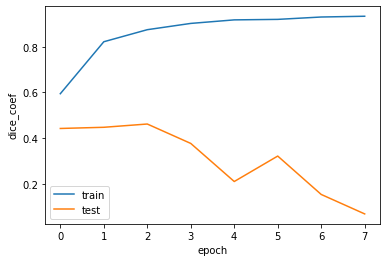

In [10]:
plt.plot(history.history['dice_coef'], label='train')
plt.plot(history.history['val_dice_coef'], label='test')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [11]:
print("dice_coef", history.history['dice_coef'][-6])
print("val_dice_coef", history.history['val_dice_coef'][-6])

dice_coef 0.8746041059494019
val_dice_coef 0.4619555175304413


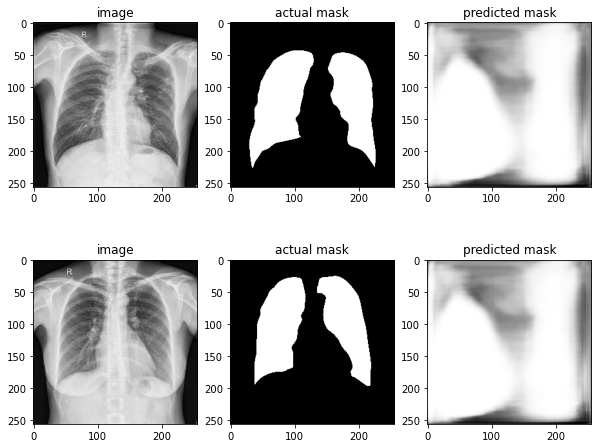

In [14]:
preds_test = model.predict(X_test)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

for i in range(2):
    for j in range(3):
        if j == 0:
            axs[i, j].imshow(X_test[i + 10], cmap='gray')
            axs[i, j].set_title('image')
        elif j == 1:
            axs[i, j].imshow(y_test[i + 10], cmap='gray')
            axs[i, j].set_title('actual mask')
       
        elif j == 2:
            axs[i, j].imshow(preds_test[i + 10], cmap='gray')
            axs[i, j].set_title('predicted mask')

(166, 256, 256, 1)


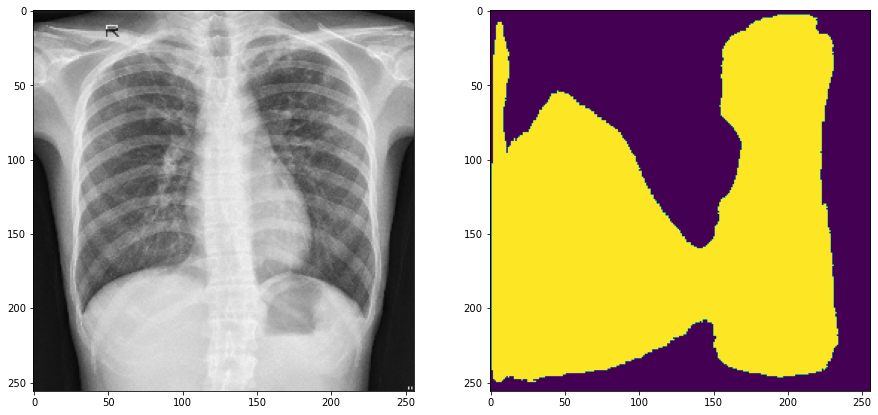

In [16]:
pred_test = model.predict(X_test)
print(pred_test.shape)

idx = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X_test[idx])
axes[1].imshow(pred_test[idx, ..., 0]> 0.9)

plt.show()

## 3. Рукописная Unet <a id='section_3'></a>

In [17]:
def Unet(num_classes=1, input_shape=(256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x, name='unet')
    return model

In [18]:
model_unet = Unet(1, (256, 256, 3))
model_unet.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                              

                                                                                                  
 block4_conv3 (Conv2D)          (None, 32, 32, 512)  2359808     ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 512)  2048       ['block4_conv3[0][0]']           
 rmalization)                                                                                     
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 64, 64, 256)  524544     ['batch_normalization_9[0][0]']  
 ose)                                                                                             
                                                                                                  
 batch_normalization_10 (BatchN  (None, 64, 64, 256)  1024       ['conv2d_transpose[0][0]']       
 ormalizat

                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_5[0][0]']               
 ormalization)                  )                                                                 
                                                                                                  
 activation_18 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_18[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 256, 1)  577         ['activation_18[0][0]']          
                                                                                                  
Total para

In [19]:
#тестирование модели перед обучением
testing_shape = np.random.randn(256, 256, 3)
testing_shape = testing_shape.reshape(-1, 256, 256, 3)
Y_pred = model_unet.predict(testing_shape)

print(Y_pred.shape)

(1, 256, 256, 1)


In [20]:
model_unet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[dice_coef])

In [21]:
%%time

early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           patience=5,
                           restore_best_weights=True)

history_unet = model_unet.fit(X_train, y_train,
            epochs=20, 
            batch_size = 32,
            verbose=1,
            callbacks=[early_stop],     
            validation_data=(X_test, y_test))

#метрики модели
test_loss_unet, test_metric_unet = model_unet.evaluate(X_test, y_test)
print(f"Test loss {test_loss_unet}, Test dice_coef {test_metric_unet}")

Epoch 1/20
13/13 [==============================] - 851s 66s/step - loss: 0.3350 - dice_coef: 0.3891 - val_loss: 0.6268 - val_dice_coef: 0.4395
Epoch 2/20
13/13 [==============================] - 1490s 119s/step - loss: 0.1287 - dice_coef: 0.3886 - val_loss: 0.9843 - val_dice_coef: 0.4395
Epoch 3/20
13/13 [==============================] - 1584s 122s/step - loss: 0.1081 - dice_coef: 0.3897 - val_loss: 0.7258 - val_dice_coef: 0.4395
Epoch 4/20
13/13 [==============================] - 1314s 100s/step - loss: 0.0896 - dice_coef: 0.3890 - val_loss: 0.7560 - val_dice_coef: 0.4395
Epoch 5/20
13/13 [==============================] - 1618s 127s/step - loss: 0.0784 - dice_coef: 0.3882 - val_loss: 0.7486 - val_dice_coef: 0.4395
Epoch 6/20
13/13 [==============================] - 1672s 130s/step - loss: 0.0725 - dice_coef: 0.3889 - val_loss: 0.6098 - val_dice_coef: 0.4395
Epoch 7/20
13/13 [==============================] - 1674s 129s/step - loss: 0.0691 - dice_coef: 0.3882 - val_loss: 0.4955 - va

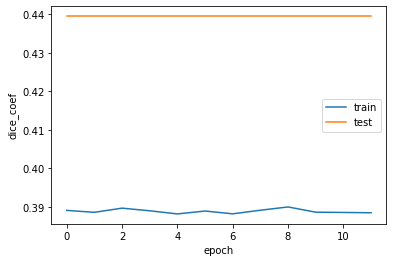

In [22]:
plt.plot(history_unet.history['dice_coef'], label='train')
plt.plot(history_unet.history['val_dice_coef'], label='test')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [23]:
print("dice_coef", history_unet.history['dice_coef'][-5])
print("val_dice_coef", history_unet.history['val_dice_coef'][-5])

dice_coef 0.3891547918319702
val_dice_coef 0.43953561782836914


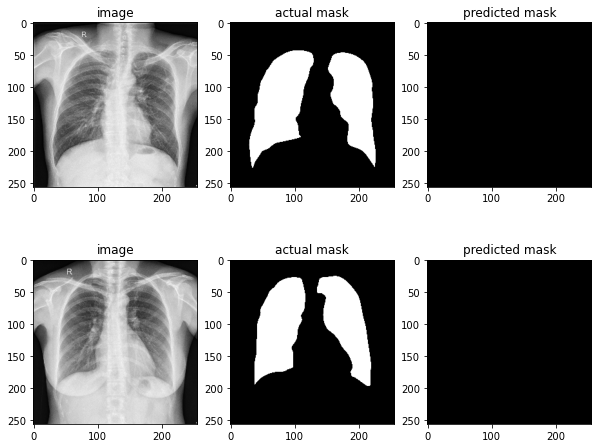

In [28]:
preds_test = model_unet.predict(X_test)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

for i in range(2):
    for j in range(3):
        if j == 0:
            axs[i, j].imshow(X_test[i + 10], cmap='gray')
            axs[i, j].set_title('image')
        elif j == 1:
            axs[i, j].imshow(y_test[i + 10], cmap='gray')
            axs[i, j].set_title('actual mask')
       
        elif j == 2:
            axs[i, j].imshow(preds_test[i + 10], cmap='gray')
            axs[i, j].set_title('predicted mask')

(166, 256, 256, 1)


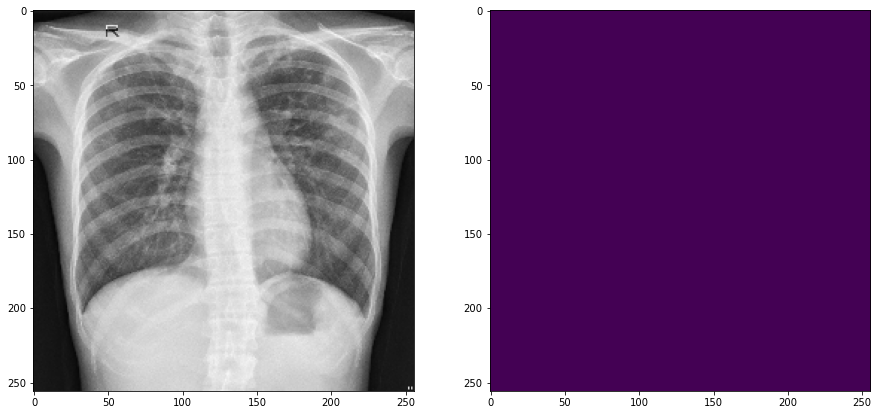

In [27]:
pred_test = model_unet.predict(X_test)
print(pred_test.shape)

idx = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X_test[idx])
axes[1].imshow(pred_test[idx, ..., 0]> 0.9)

plt.show()

## 4. Выводы о результатах нейросетей <a id='section_4'></a>

На основе результатов работы моделей Unet в пунктах 2 и 3 можно сформулировать следующие выводы:

0. Метрика на валидации немонотонно, но быстро убывает на множестве эпох. 
1. Увеличению метрики на валидации способствуют:
  - увеличение batch_size,
  - увеличение числа эпох,
  - использование оптимизатора adam,
  - увеличение отсечки определения метки класса.
2. Обучение модели занимает большое время.
3. При обучении моделей полезен Earlystop (сокращает время обучения).
4. Модель из пункта 2 (Segmantational model Unet) сильно переобучена.
5. Модель из пункта 3 (рукопиcная Unet) имеет стабильную метрику на тесте и валидации только изменяющийся loss.
6. Результат работы модели из пункта 2 лучше, чем из пункта 3 (см. визуализацию предсказаний).